# Genome scale model reconstruction of the methylotrophic yeast *Ogataea polymorpha*: Reproduction of simulations of iUL909 with CobraPy Notebook

## Introduction

This notebook is an extension to the article by Liebal et al., (2020) and reproduces the comparison of experimental growth rates with predictions by the genome scale metabolic model (GSMM) of *Ogataea polymorpha* iUL909. Finaly, the Memote quality check is performed. 

## Requirements
Make sure that the required files are present in the notebook directory. 

Files:
 * iUL909.xml: SBML file, Genome scale metabolic model of *O. polymorpha*, relative location `../model/iUL909.xml`
 * iOpol_Additional_File_2.xlsx: Excel file, contains the literature growth rates and uptake rate in sheet 'Literature_Chemostat', relative location `../data/AdditionalData/iOpol_Additional_File_2.xlsx`
 
Dependencies:
 * CPython 3.7.6
 * IPython 7.12.0
 * ipywidgets 7.5.1
 * matplotlib 3.1.3
 * numpy 1.18.1
 * pandas 1.0.1
 * cobra 0.17.1
 * memote 0.10.2

## Set-up compute environment 

In the following cell the python environment is set up. If CobraPy and Memote are not already downloaded then install them using pip or use the following command to download the packages them from the cell:
`!{sys.executable} -m pip install cobra`

In [1]:
import sys # loading commands to control/navigate within the system architecture
# Loading pandas, a library for data manipulation
import os
import xlrd
import pandas as pd
# import lxml

# Loading numpy, a library fo manipulation of numbers
import numpy as np

# loading matplotlib, a library for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# loading cobrapy, a library dedicated to the analysis of genome scale metabolic models
from cobra.io import read_sbml_model, write_sbml_model

# loading Memote, quality assessment of GSMM
from memote import test_model, snapshot_report

## Data loading

Now, the external data is integrated. The excel-sheet is parsed and the GSMM file is converted to a model variable.

In [2]:
# assuming the base path is in 'Simulation'
myxls = os.path.join('..','data','AdditionalData','iOpol_Additional_File_2.xlsx')
x1 = pd.ExcelFile(myxls)
df1 = x1.parse('Literature_Chemostat')
df1.head(9)

,Substrate,Exchange,uptake rate (mmol/gCDW/h),growth rate (/h),yield (gCDW/gMeOH),source
0,Glucose,Ex_glc_D,5.900000,0.600,NaN,Lehnen et al. (10.1016/j.meteno.2017.07.001)
1,Methanol,Ex_meoh,2.343750,0.024,0.32,van Dijken et al. (Fig.6)(10.1007/BF00446560)
2,Methanol,Ex_meoh,2.935606,0.031,0.33,van Dijken et al. (Fig.6)(10.1007/BF00446560)
3,Methanol,Ex_meoh,4.285714,0.048,0.35,van Dijken et al. (Fig.6)(10.1007/BF00446560)
4,Methanol,Ex_meoh,5.827703,0.069,0.37,van Dijken et al. (Fig.6)(10.1007/BF00446560)
5,Methanol,Ex_meoh,6.578947,0.080,0.38,van Dijken et al. (Fig.6)(10.1007/BF00446560)
6,Methanol,Ex_meoh,9.868421,0.120,0.38,van Dijken et al. (Fig.6)(10.1007/BF00446560)
7,Methanol,Ex_meoh,14.285714,0.160,0.35,van Dijken et al. (Fig.6)(10.1007/BF00446560)
8,Glycerol,Ex_glyc,7.125407,0.420,0.64,growth rate: de Koning et al. (10.1007/BF00456...


## Model loading

In [3]:
# generating cobra variable from SBML/xml file
# assuming the base path is in 'Simulation'
myFile = os.path.join('..','model','iUL909.xml') # os.path.join('..','iUL_versions','iUL959_112718.xml')
model = read_sbml_model(myFile)
# peroxisomal transaldolase reaction increases biomass unrealistically, setting reverse reaction to zero
# model.reactions.TALAx.upper_bound = 1000
model

Name,COBRAModel
Memory address,0x07f94d18b53d0
Number of metabolites,1637
Number of reactions,2263
Number of groups,39
Objective expression,1.0*BIOMASS - 1.0*BIOMASS_reverse_69053
Compartments,"c, m, r, e, x, v, n, g, i"


## Function definitions

We are testing three different growth conditions with substrates methanol, glycerol, and glucose. For each of the substrates, the corresponding exchange rate has to be activated, the approriate biomass composition formula has to be selected and exchange reactions for non-used substrates need to be closed.

In [4]:
def AdaptMethanol(model, meoh_up):
  # setting uptake reactions right
  model.reactions.Ex_glc_D.lower_bound = 0
  model.reactions.Ex_glyc.lower_bound = 0
  model.reactions.Ex_meoh.lower_bound = -np.abs(meoh_up)
  # setting additional biomass composition
  model.reactions.LIPIDS_meoh.upper_bound = 1000
  model.reactions.PROTEINS_meoh.upper_bound = 1000
  model.reactions.STEROLS_meoh.upper_bound = 1000
  model.reactions.BIOMASS_meoh.upper_bound = 1000
  # deactivating Glc-based biomass composition
  model.reactions.LIPIDS.upper_bound = 0
  model.reactions.PROTEINS.upper_bound = 0
  model.reactions.STEROLS.upper_bound = 0
  model.reactions.BIOMASS.upper_bound = 0  
  model.objective = 'BIOMASS_meoh'
  return model

def AdaptGlucose(model, glc_up):
  # setting uptake reactions right
  model.reactions.Ex_meoh.lower_bound = 0
  model.reactions.Ex_glyc.lower_bound = 0
  model.reactions.Ex_glc_D.lower_bound = -np.abs(glc_up)
  # setting additional biomass composition
  model.reactions.LIPIDS.upper_bound = 1000
  model.reactions.PROTEINS.upper_bound = 1000
  model.reactions.STEROLS.upper_bound = 1000
  model.reactions.BIOMASS.upper_bound = 1000  
  # deactivating Glc-based biomass composition
  model.reactions.LIPIDS_meoh.upper_bound = 0
  model.reactions.PROTEINS_meoh.upper_bound = 0
  model.reactions.STEROLS_meoh.upper_bound = 0
  model.reactions.BIOMASS_meoh.upper_bound = 0
  model.objective = 'BIOMASS'
  return model

def AdaptGlycerol(model, glyc_up):
  # setting uptake reactions right
  model.reactions.Ex_meoh.lower_bound = 0;
  model.reactions.Ex_glc_D.lower_bound = 0;
  model.reactions.Ex_glyc.lower_bound = -np.abs(glyc_up)
  # setting additional biomass composition
  model.reactions.LIPIDS.upper_bound = 1000
  model.reactions.PROTEINS.upper_bound = 1000
  model.reactions.STEROLS.upper_bound = 1000
  model.reactions.BIOMASS_glyc.upper_bound = 1000  
  # deactivating Glc-based biomass composition
  model.reactions.LIPIDS_meoh.upper_bound = 0
  model.reactions.PROTEINS_meoh.upper_bound = 0
  model.reactions.STEROLS_meoh.upper_bound = 0
  model.reactions.BIOMASS_meoh.upper_bound = 0
  model.objective = 'BIOMASS_glyc'
  return model

print('Growth functions defined.')

Growth functions defined.


## Simulation

Here, we start the simulation loop. For all substrates we use the substrate uptake rate and use the functions defined previously to update the model. The final growth rate is stored, and is then used in a plot versus the experimentally observed growth.

In [5]:
model_loop = model.copy()
growth_simulated = [];
for index, row in df1.iterrows():
  print(index)
  if row['Substrate'] == 'Methanol':
    model_loop = AdaptMethanol(model_loop, row['uptake rate (mmol/gCDW/h)'])
  elif row['Substrate'] == 'Glucose':
    model_loop = AdaptGlucose(model_loop, row['uptake rate (mmol/gCDW/h)'])
  elif row['Substrate'] == 'Glycerol':
    model_loop = AdaptGlycerol(model_loop, row['uptake rate (mmol/gCDW/h)'])
  else:
    print('substrate not considered')      
  model_loop.optimize()
  growth_simulated.append(model_loop.objective.value)


0
1
2
3
4
5
6
7
8


## Visualization

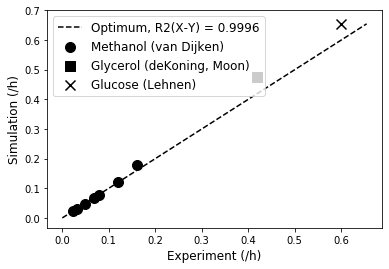

In [6]:
plt.rc('axes', labelsize=12) 
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plt.rc('legend', fontsize=12) 
# plt.figure(figsize=(4,3))
plt.scatter(df1['growth rate (/h)'][1:8], growth_simulated[1:8], s=100, c='k', marker='o', );
plt.scatter(df1['growth rate (/h)'][8], growth_simulated[8], s=100, c='k', marker='s');
plt.scatter(df1['growth rate (/h)'][0], growth_simulated[0], s=100, c='k', marker='x');
plt.xlabel('Experiment (/h)');
plt.ylabel('Simulation (/h)');
myline = np.linspace(0,np.max(growth_simulated),10);
plt.plot(myline,myline,'k--');
# plt.title('Growth rate comparison');
# correlation coefficient between experimental and simulated data
R2 = np.corrcoef(np.array([growth_simulated[0:9],df1['growth rate (/h)'][0:9]]))
R2Legend = 'Optimum, R2(X-Y) = %.4f'%(R2[0,1]) 
plt.legend([R2Legend,'Methanol (van Dijken)','Glycerol (deKoning, Moon)','Glucose (Lehnen)'], loc=2);
plt.style.use('seaborn-paper')
# plt.savefig('iOpol_growth_exp-vs-sim.png', bbox_inches='tight')
# plt.savefig('iOpol_growth_exp-vs-sim.pdf', bbox_inches='tight')

## Memote quality test

Memote performs quality assessments of genome scale metabolic models. The process can take a while, around 5 min.

In [ ]:
mem_return, mem_result = test_model(model, results=True)
with open('iOpol_MemoteReport.html', 'w') as f:
    f.write(snapshot_report(mem_result))



### Mass balance test

In [ ]:
import json

# myFile = os.path.join('..','iUL_versions','iUL959_200810.xml') # os.path.join('..','iUL_versions','frank','out_metadata.xml') # os.path.join('..','iUL_versions','iUL959_112718.xml')
# model = read_sbml_model(myFile)
mysol = [[reaction.id, reaction.reaction, reaction.check_mass_balance()] for reaction in model.reactions if reaction.check_mass_balance()]
print('unbalanced reactions: {}'.format(len(mysol)))
df_mysol = pd.DataFrame(mysol, columns=['Abbreviation','Formula','Misbalance'])

# deleting reactions with following strings
DelStr_all = ['Ex_', 'avg', 'BIOM', 'PROT', 'LIP', 'STER', 'DNA', 'RNA', 'CARB', 'GLYCE']
for DelStr in DelStr_all:
    indices = [i for i, s in enumerate(list(df_mysol['Abbreviation'])) if DelStr in s]
    df_mysol.drop(df_mysol.index[[indices]], inplace=True)
    
df_mysol.reset_index(inplace=True)
df_mysol.to_csv('iOpol_unbalanced.txt', index=False)

df_mysol


In [7]:
model.optimize()
print(model.summary())
[reaction.flux for reaction in model.reactions.query('TRNA')]
print(model.metabolites.get_by_id('fum[c]').summary())

IN_FLUXES IN_FLUXES  OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX        ID        FLUX        ID        FLUX   
    o2[e]    18.5        h2o[e]    33.7      BIOMASS     1.12   
 glc_D[e]      10        co2[e]      20                   nan   
   nh4[e]     6.4          h[e]    6.27                   nan   
              nan    biomass[e]    1.12                   nan   
                  PERCENT  FLUX         REACTION_STRING         
RXN_STAT  ID                                                    
PRODUCING ARGSL    49.9   0.252  argsuc[c] <=> arg_L[c] + fum[c]
          ADSL1r   26.4   0.133     dcamp[c] <=> amp[c] + fum[c]
          ADSL2r   23.7   0.119  25aics[c] <=> aicar[c] + fum[c]
CONSUMING FUM       100   0.504     fum[c] + h2o[c] <=> mal_L[c]


cobra/core/summary/summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.
cobra/core/summary/summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


### Dependencies and versions
The code below was used to identify the versions of dependent packages.

In [ ]:
%load_ext watermark
%watermark -v -m -p ipywidgets,matplotlib,numpy,pandas,cobra,memote,watermark